In [1]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from random import randint
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

In [2]:
train_input , train_target = bci.load ( root = "./ data_bci")
test_input , test_target = bci.load ( root = "./ data_bci " , train = False )

train_target = Variable(train_target)
train_input  = Variable(train_input.unsqueeze(dim=2))
test_input   = Variable(test_input.unsqueeze(dim=2))
test_target  = Variable(test_target)

mu, std = train_input.data.mean(), train_input.data.std() 
train_input.data.sub_(mu).div_(std)
test_input.data.sub_(mu).div_(std)


print ('train_input size:' , train_input.size())
print ('train_target size:' , train_target.size())
print ('test_input size:' , test_input.size())
print ('test_target size:' , test_target.size())

('train_input size:', torch.Size([316, 28, 1, 50]))
('train_target size:', torch.Size([316]))
('test_input size:', torch.Size([100, 28, 1, 50]))
('test_target size:', torch.Size([100]))


In [3]:
# The function computes the accuracy
def accuracy(output,target):
    return (output.float()==target.float()).float().sum()/len(output)

## Preparing the data

In [4]:
class Dataset:
    def __init__(self,train_data,train_target):
        self.train_data = train_data.data
        self.train_target = train_target
    def __getitem__(self, index):
        return self.train_data[index], self.train_target[index]
    def __len__(self):
        return len(self.train_target)

In [5]:
data = Dataset(train_input,train_target)
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size = 40, shuffle=True,
                                             num_workers=4)

# Plotting the dataset

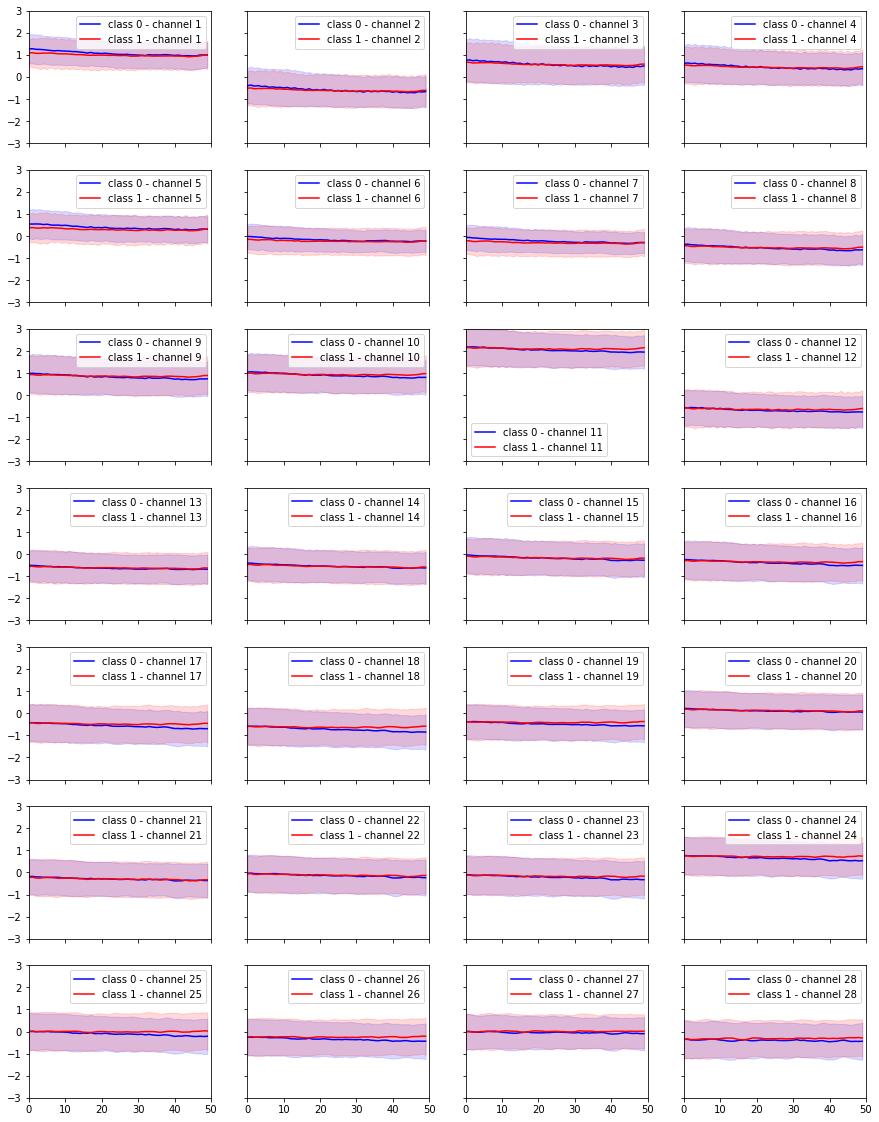

In [7]:
class0 = train_input[(train_target == 0).nonzero(),].squeeze_(1)       # torch.Size([159, 28, 1, 50])
class1 = train_input[(train_target == 1).nonzero(),].squeeze_(1)       # torch.Size([157, 28, 1, 50])

N0 = len(class0)
N1 = len(class1)

Fig = plt.figure()
Fig.set_figheight(20)
Fig.set_figwidth(15)
time = list(range(class0.data.shape[3]))
for c in range(28):
    
    mean0 = class0.data[:,c,0,:].mean(0)
    std0  = class0.data[:,c,0,:].std(0)
    
    mean1 = class1.data[:,c,0,:].mean(0)
    std1  = class1.data[:,c,0,:].std(0)
    
    
    Fig.add_subplot(7,4,c+1)
    ax=plt.gca()
    if (c%4!=0):
        plt.setp(ax.get_yticklabels(), visible=False)
    if (c<24):
        plt.setp(ax.get_xticklabels(), visible=False)
        
    plt.plot(mean0.numpy(),label='class 0 - channel '+str(c+1), color='b')
    plt.fill_between(time, mean0-std0 , mean0+std0 ,alpha=0.15, color='b')
    
    plt.plot(mean1.numpy(),label='class 1 - channel '+str(c+1), color='r')
    plt.fill_between(time, mean1-std1 , mean1+std1 ,alpha=0.15, color='r')
    
    plt.xlim(0,50)
    plt.ylim(-3,3)
    plt.legend(loc=0)
plt.show()

## Convolutional neural network

We build a network composed of two Conv layers, two FC with average pooling and dropout.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d (28, 32, kernel_size = (1,5))    # after conv: 20*32*1*46
        self.avg_pool1 = nn.AvgPool2d(kernel_size = (1,4))      # size -> 1/4 *size
        self.conv2 = nn.Conv2d (32 , 64, kernel_size = (1,5))   
        self.fc1 = nn.Linear (448 , 50)                         # size : 64 ->32 => 448/2
        self.dr = nn.Dropout(p=0.8)
        self.fc2 = nn.Linear (50 , 2)
        
    def forward (self , x):
        x = self.conv1(x)
        x = F.relu(self.avg_pool1(x))
        x = F.relu(self.conv2(x))
        x = x.view (-1, 448)
        x = self.dr(x)
        x = F.relu ( self.fc1 (x))
        x = self.dr(x)
        x = self.fc2(x)
                   #x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 3, stride =3) )
        #x = F.relu (F.max_pool2d ( self.conv2(x), kernel_size =2, stride =2) )
        return x


In [9]:
### train the model
net = Net()
epoch = 1000
batch_size = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.5)


i = 0
for e in range(epoch):
    for b in range(0,train_input.size(0),batch_size):
        input_ = train_input.narrow(0,b,min(batch_size,train_input.size(0)-b))
        target = train_target.narrow(0,b,min(batch_size,train_input.size(0)-b))
        output = net(input_).view(min(batch_size,train_input.size(0)-b),2)
        loss = criterion(output,target)
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%10 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output.max(dim=1)
        
        #predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print('epoch: {:2d}    loss train: {:6f}    loss test: {:6f}    test accuracy: {:03.3f}'.format( (e//10),
                                    criterion(output_train,train_target).data[0],
                                    criterion(output,test_target).data[0], 
                                    accuracy(predicted_class,test_target).data[0]) )
        

epoch:  0    loss train: 0.699558    loss test: 0.695502    test accuracy: 0.500
epoch:  1    loss train: 0.695822    loss test: 0.700281    test accuracy: 0.480
epoch:  2    loss train: 0.688727    loss test: 0.705669    test accuracy: 0.430
epoch:  3    loss train: 0.686324    loss test: 0.708372    test accuracy: 0.510
epoch:  4    loss train: 0.680336    loss test: 0.699540    test accuracy: 0.480
epoch:  5    loss train: 0.688355    loss test: 0.699087    test accuracy: 0.510
epoch:  6    loss train: 0.675110    loss test: 0.712127    test accuracy: 0.500
epoch:  7    loss train: 0.684015    loss test: 0.693784    test accuracy: 0.530
epoch:  8    loss train: 0.672304    loss test: 0.716451    test accuracy: 0.490
epoch:  9    loss train: 0.653894    loss test: 0.719348    test accuracy: 0.500
epoch: 10    loss train: 0.648331    loss test: 0.701649    test accuracy: 0.500
epoch: 11    loss train: 0.627518    loss test: 0.692406    test accuracy: 0.610
epoch: 12    loss train: 0.6

## Data Augmentaiotn: Averaging two datapoints in the same class

In [13]:

train_input_aug0 = [(class0[i]+class0[j])/2 for i in range(N0) for j in range(i,N0)]
train_input_aug0 = torch.stack(train_input_aug0)
train_out_aug0 = Variable(Tensor(train_input_aug0.shape[0]).fill_(0))

train_input_aug1 = [(class1[i]+class1[j])/2 for i in range(N1) for j in range(i,N1)]
train_input_aug1 = torch.stack(train_input_aug1)
train_out_aug1 = Variable(Tensor(train_input_aug1.shape[0]).fill_(1))

###
train_aug = torch.cat((train_input_aug0,train_input_aug1))
train_target_aug = torch.cat((train_out_aug0,train_out_aug1)).data.long()

mu, std = train_aug.data.mean(), train_aug.data.std() ;
train_aug.data.sub_(mu).div_(std);
test_input.data.sub_(mu).div_(std);

In [14]:
(train_aug.data.shape)

torch.Size([25123, 28, 1, 50])

In [15]:
data = Dataset(train_aug,train_target_aug)
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size = 40, shuffle=True,
                                             num_workers=4)

In [16]:
net = Net()

In [18]:
### train the model
epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.5)
i = 0
for e in range(epoch):
    for input_, target_ in dataset_loader:
        input_ = Variable(input_)
        target_ = Variable(target_)
        output = net(input_).view(-1,2)
        loss = criterion(output,target_) 
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%1 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output.max(dim=1)
        #predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print('epoch: {:2d}    loss train: {:6f}    loss test: {:6f}    test accuracy: {:03.3f}'.format( (e),
                                    criterion(output_train,train_target).data[0],
                                    criterion(output,test_target).data[0], 
                                    accuracy(predicted_class,test_target).data[0]) )
        

epoch:  0    loss train: 0.209622    loss test: 0.931931    test accuracy: 0.810
epoch:  1    loss train: 0.534615    loss test: 1.456664    test accuracy: 0.690
epoch:  2    loss train: 0.213724    loss test: 0.839604    test accuracy: 0.800
epoch:  3    loss train: 0.547714    loss test: 2.000546    test accuracy: 0.730
epoch:  4    loss train: 0.353022    loss test: 1.144539    test accuracy: 0.770
epoch:  5    loss train: 0.241043    loss test: 1.019262    test accuracy: 0.760
epoch:  6    loss train: 0.167674    loss test: 1.081544    test accuracy: 0.810
epoch:  7    loss train: 0.151519    loss test: 1.087019    test accuracy: 0.830
epoch:  8    loss train: 0.129975    loss test: 1.387147    test accuracy: 0.790
epoch:  9    loss train: 0.254223    loss test: 2.258352    test accuracy: 0.750


## Adding L1 reguralizer

In [21]:
def l1_reguralizer(paramters):
    loss = 0
    for p in paramters:
        loss += torch.abs(p).mean()
    return loss

In [22]:
net = Net()

In [23]:

### train the model
epoch = 100
lambda_ = 10**-2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.5)
i = 0
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []
for e in range(epoch):
    if e == 30:
        optimizer = optim.SGD(net.parameters(),lr = 0.003,momentum = 0.5)
    if e== 60:
        optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.5)
    for input_, target_ in dataset_loader:
        input_ = Variable(input_)
        target_ = Variable(target_)
        output = net(input_).view(-1,2)
        loss = criterion(output,target_) + lambda_ * l1_reguralizer(net.parameters())
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    if e%1 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output_train.max(dim=1)
        accuracy_train.append(accuracy(predicted_class_train,train_target).data[0])
        accuracy_test.append(accuracy(predicted_class,test_target).data[0])
        loss_train.append(criterion(output_train,train_target).data[0]+ lambda_ * l1_reguralizer(net.parameters()).data[0])
        loss_test.append(criterion(output,test_target).data[0]+ lambda_ * l1_reguralizer(net.parameters()).data[0])
        print('epoch: {:2d}    train loss: {:6f}    train accuracy: {:03.3f}    test loss: {:6f}    test accuracy: {:03.3f}'
                                    .format( (e//1), loss_train[-1], accuracy_train[-1], loss_test[-1], accuracy_test[-1]))
        
        
        

epoch:  0    train loss: 0.684818    train accuracy: 0.557    test loss: 0.703102    test accuracy: 0.570
epoch:  1    train loss: 0.666935    train accuracy: 0.611    test loss: 0.725110    test accuracy: 0.620
epoch:  2    train loss: 0.535886    train accuracy: 0.725    test loss: 0.669787    test accuracy: 0.720
epoch:  3    train loss: 1.015928    train accuracy: 0.620    test loss: 1.583620    test accuracy: 0.620
epoch:  4    train loss: 0.413662    train accuracy: 0.829    test loss: 0.749713    test accuracy: 0.780
epoch:  5    train loss: 0.476548    train accuracy: 0.797    test loss: 0.808318    test accuracy: 0.710
epoch:  6    train loss: 0.376823    train accuracy: 0.854    test loss: 1.113816    test accuracy: 0.710
epoch:  7    train loss: 0.313555    train accuracy: 0.880    test loss: 1.048211    test accuracy: 0.750
epoch:  8    train loss: 1.069096    train accuracy: 0.747    test loss: 1.559977    test accuracy: 0.680
epoch:  9    train loss: 0.258182    train acc

epoch: 78    train loss: 0.057373    train accuracy: 0.991    test loss: 2.379779    test accuracy: 0.780
epoch: 79    train loss: 0.037242    train accuracy: 0.984    test loss: 2.329100    test accuracy: 0.790
epoch: 80    train loss: 0.052050    train accuracy: 0.981    test loss: 3.646585    test accuracy: 0.800
epoch: 81    train loss: 0.042251    train accuracy: 0.978    test loss: 2.630546    test accuracy: 0.800
epoch: 82    train loss: 0.064095    train accuracy: 0.981    test loss: 2.698942    test accuracy: 0.790
epoch: 83    train loss: 0.063215    train accuracy: 0.978    test loss: 3.309024    test accuracy: 0.770
epoch: 84    train loss: 0.064203    train accuracy: 0.991    test loss: 3.723715    test accuracy: 0.780
epoch: 85    train loss: 0.059922    train accuracy: 0.984    test loss: 2.984055    test accuracy: 0.790
epoch: 86    train loss: 0.118219    train accuracy: 0.972    test loss: 3.514931    test accuracy: 0.800
epoch: 87    train loss: 0.034058    train acc

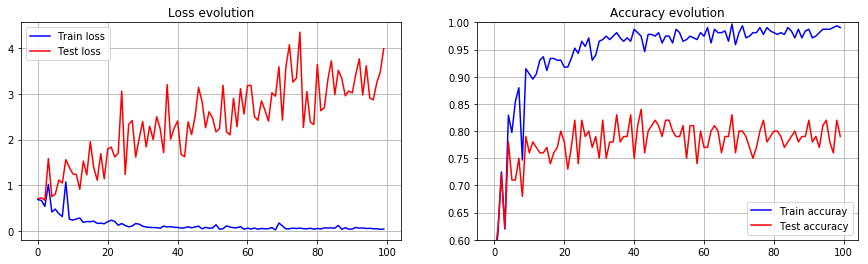

In [28]:
Fig=plt.figure()
Fig.set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(loss_train, label='Train loss', color='b' )
plt.plot(loss_test, label='Test loss', color='r')
plt.title('Loss evolution')
plt.grid(True)
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(accuracy_train, label='Train accuray', color='b' )
plt.plot(accuracy_test, label='Test accuracy', color='r')
plt.title('Accuracy evolution')
plt.ylim(0.6,1)
plt.grid(True)
plt.legend(loc=0)



## Average between 3

In [59]:
class0 = train_input[(train_target == 0).nonzero(),]
class1 = train_input[(train_target == 1).nonzero(),]
class0.squeeze_(dim=1)
class1.squeeze_(dim=1)

N = class0.shape[0]
train_input_aug0 = [(class0[randint(0,N-1)]+class0[randint(0,N-1)]+ class0[randint(0,N-1)])/3 for i in range(200*10**3)]
train_input_aug0 = torch.stack(train_input_aug0)
train_out_aug0 = Variable(Tensor(train_input_aug0.shape[0]).fill_(0))
N = class1.shape[0]
train_input_aug1 = [(class0[randint(0,N-1)]+class0[randint(0,N-1)]+ class0[randint(0,N-1)])/3 for i in range(200*10**3)]
train_input_aug1 = torch.stack(train_input_aug1)
train_out_aug1 = Variable(Tensor(train_input_aug1.shape[0]).fill_(1))

###
train_aug = torch.cat((train_input_aug0,train_input_aug1))
train_target_aug = torch.cat((train_out_aug0,train_out_aug1)).data.long()

In [61]:
data = Dataset(train_aug,train_target_aug)
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size = 100, shuffle=True,
                                             num_workers=4)

In [62]:
net = Net()

In [70]:
### train the model
epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.0001,momentum = 0.5)
i = 0
for e in range(epoch):
    for input_, target_ in dataset_loader:
        input_ = Variable(input_)
        target_ = Variable(target_)
        output = net(input_).view(-1,2)
        loss = criterion(output,target_)
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%1 == 0: # print the loss every 10 epochs
        output = net(test_input).view(-1,2)
        a,predicted_class = output.max(dim=1)
        output_train = net(train_input).view(-1,2)
        a,predicted_class_train = output.max(dim=1)
        #predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print(e//1,'loss train:',criterion(output_train,train_target).data[0],'loss test:',criterion(output,test_target).data[0],' accuracy test:',accuracy(predicted_class,test_target).data[0])
        print('epoch: {:2d}    train loss: {:6f}    train accuracy: {:03.3f}    test loss: {:6f}    test accuracy: {:03.3f}'
                                    .format( (e//1), loss_train[-1], accuracy_train[-1], loss_test[-1], accuracy_test[-1]))
        
        

0 loss train: 0.972797155380249 loss test: 1.0354115962982178  accuracy test: 0.47999998927116394
1 loss train: 0.9761149883270264 loss test: 1.1677064895629883  accuracy test: 0.5099999904632568
2 loss train: 0.9124852418899536 loss test: 0.981426477432251  accuracy test: 0.49000000953674316
3 loss train: 0.9623199701309204 loss test: 1.0508921146392822  accuracy test: 0.47999998927116394
4 loss train: 0.9801075458526611 loss test: 1.0371037721633911  accuracy test: 0.47999998927116394
5 loss train: 0.9583073854446411 loss test: 1.1277952194213867  accuracy test: 0.5099999904632568
6 loss train: 0.9784257411956787 loss test: 1.0535842180252075  accuracy test: 0.46000000834465027
7 loss train: 0.9714837670326233 loss test: 1.118096947669983  accuracy test: 0.44999998807907104
8 loss train: 0.9817187190055847 loss test: 1.2405074834823608  accuracy test: 0.5199999809265137
9 loss train: 0.9704495072364807 loss test: 1.1885745525360107  accuracy test: 0.5099999904632568
